In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import math
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import keras.backend as K

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("github")

#plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
#plt.rc('figure', autolayout=True)
#plt.rc('axes', labelweight='bold', labelsize='large',
#       titleweight='bold', titlesize=18, titlepad=10)
#plt.rc('animation', html='html5')


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

def angular_dist_score(y_true, y_pred):
    az_true = y_true[:,0]
    zen_true = y_true[:,1]
    az_pred = y_pred[:,0]
    zen_pred = y_pred[:,1]
    #if not (tf.all(tf.isfinite(az_true)) and
    #        tf.all(tf.isfinite(zen_true)) and
    #        tf.all(tf.isfinite(az_pred)) and
    #        tf.all(tf.isfinite(zen_pred))):
    #    raise ValueError("All arguments must be finite")
    
    # pre-compute all sine and cosine values
    sa1 = tf.sin(az_true)
    ca1 = tf.cos(az_true)
    sz1 = tf.sin(zen_true)
    cz1 = tf.cos(zen_true)

    sa2 = tf.sin(az_pred)
    ca2 = tf.cos(az_pred)
    sz2 = tf.sin(zen_pred)
    cz2 = tf.cos(zen_pred)

    # scalar product of the two cartesian vectors (x = sz*ca, y = sz*sa, z = cz)
    scalar_prod = sz1*sz2*(ca1*ca2 + sa1*sa2) + (cz1*cz2)

    # scalar product of two unit vectors is always between -1 and 1, this is against numerical instability
    # that might otherwise occure from the finite precision of the sine and cosine functions
    scalar_prod =tf.clip_by_value(scalar_prod, -1, 1)

    # convert back to an angle (in radian)
    return tf.math.reduce_mean(tf.abs(tf.acos(scalar_prod)))

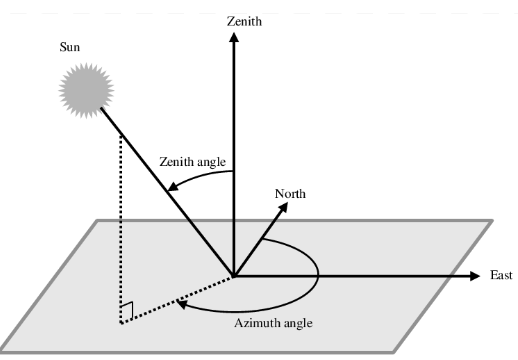

In [2]:
#Read files
df = pd.read_parquet('/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_2.parquet').reset_index()

res = pd.read_parquet('/kaggle/input/icecube-neutrinos-in-deep-ice/train_meta.parquet')

geom = pd.read_csv('/kaggle/input/icecube-neutrinos-in-deep-ice/sensor_geometry.csv')

#Filters on events

df = df[df['auxiliary']==False]

df = df.drop(labels='auxiliary', axis=1)

df.head()


,event_id,sensor_id,time,charge
12,3266199,1775,9877,0.575
13,3266199,1775,9882,1.225
14,3266199,1775,9888,0.975
15,3266199,1775,9893,0.975
16,3266199,1775,9908,1.025


In [3]:
#Geometrical stuff

geom['sensor_azimuth'] = np.arctan(geom['y']/geom['x'])
geom['sensor_zenith'] = np.arctan(np.sqrt(geom['x']**2 + geom['y']**2)/geom['z'])

geom.head()


,sensor_id,x,y,z,sensor_azimuth,sensor_zenith
0,0,-256.14,-521.08,496.03,1.113927,0.863814
1,1,-256.14,-521.08,479.01,1.113927,0.881007
2,2,-256.14,-521.08,461.99,1.113927,0.898702
3,3,-256.14,-521.08,444.97,1.113927,0.916909
4,4,-256.14,-521.08,427.95,1.113927,0.935639


In [4]:
#add spacial positions of sensor on dataframe

df['charge'].astype(np.float16()) 
df_with_geom = df.merge(geom, how = 'left', on = 'sensor_id').reset_index(drop = True)
#df_with_geom = df_with_geom.merge(res, how = 'left', on = 'event_id').reset_index(drop = True)
#res = res.drop(labels = ['batch_id', 'first_pulse_index', 'last_pulse_index'], axis= 1)
#df_with_geom = df_with_geom.drop(['x', 'y', 'z'], axis = 1)
df_with_geom.head(15)


,event_id,sensor_id,time,charge,x,y,z,sensor_azimuth,sensor_zenith
0,3266199,1775,9877,0.575,500.43,-58.45,-93.87,-0.116273,-1.386596
1,3266199,1775,9882,1.225,500.43,-58.45,-93.87,-0.116273,-1.386596
2,3266199,1775,9888,0.975,500.43,-58.45,-93.87,-0.116273,-1.386596
3,3266199,1775,9893,0.975,500.43,-58.45,-93.87,-0.116273,-1.386596
4,3266199,1775,9908,1.025,500.43,-58.45,-93.87,-0.116273,-1.386596
5,3266199,1776,9912,0.725,500.43,-58.45,-110.89,-0.116273,-1.354157
6,3266199,1775,9916,0.975,500.43,-58.45,-93.87,-0.116273,-1.386596
7,3266199,1775,9925,0.975,500.43,-58.45,-93.87,-0.116273,-1.386596
8,3266199,1776,9966,1.575,500.43,-58.45,-110.89,-0.116273,-1.354157
9,3266199,1775,9988,0.875,500.43,-58.45,-93.87,-0.116273,-1.386596


In [5]:
del df

In [6]:
df_with_geom = df_with_geom.drop(labels=['x', 'y', 'z'], axis=1)

In [7]:
#df_with_geom = df_with_geom.groupby(['event_id']).apply(lambda s: s.sort_values(by='time')).reset_index(drop = True)
df_with_geom = df_with_geom.sort_values('charge', ascending = False).drop_duplicates(['event_id', 'sensor_id']).sort_index()


df_with_geom.head(25)

,event_id,sensor_id,time,charge,sensor_azimuth,sensor_zenith
11,3266199,1775,10004,1.375,-0.116273,-1.386596
13,3266199,1776,10047,1.925,-0.116273,-1.354157
14,3266199,1774,10059,1.075,-0.116273,-1.419432
17,3266199,1166,10969,1.475,-0.569066,1.427733
19,3266199,1105,11028,1.875,-0.783732,1.334892
21,3266199,1106,11034,1.025,-0.783732,1.389699
22,3266199,1107,11066,1.275,-0.783732,1.445661
26,3266199,1167,11122,1.625,-0.569066,1.470974
27,3266199,1104,11173,1.275,-0.783732,1.281491
30,3266199,1109,11932,0.925,-0.783732,1.559557


In [8]:
df_with_geom['n_counter'] = df_with_geom.groupby('event_id').cumcount()
df_with_geom

,event_id,sensor_id,time,charge,sensor_azimuth,sensor_zenith,n_counter
11,3266199,1775,10004,1.375,-0.116273,-1.386596,0
13,3266199,1776,10047,1.925,-0.116273,-1.354157,1
14,3266199,1774,10059,1.075,-0.116273,-1.419432,2
17,3266199,1166,10969,1.475,-0.569066,1.427733,3
19,3266199,1105,11028,1.875,-0.783732,1.334892,4
...,...,...,...,...,...,...,...
22726668,6517807,2333,12357,0.675,0.031557,-0.799732,12
22726669,6517807,1735,12358,1.175,-0.243179,-0.723330,13
22726670,6517807,2337,12365,1.475,0.031557,-0.721389,14
22726671,6517807,1737,12462,1.025,-0.243179,-0.686039,15


In [9]:
df_with_geom  = df_with_geom[df_with_geom.n_counter<100]
df_with_geom

,event_id,sensor_id,time,charge,sensor_azimuth,sensor_zenith,n_counter
11,3266199,1775,10004,1.375,-0.116273,-1.386596,0
13,3266199,1776,10047,1.925,-0.116273,-1.354157,1
14,3266199,1774,10059,1.075,-0.116273,-1.419432,2
17,3266199,1166,10969,1.475,-0.569066,1.427733,3
19,3266199,1105,11028,1.875,-0.783732,1.334892,4
...,...,...,...,...,...,...,...
22726668,6517807,2333,12357,0.675,0.031557,-0.799732,12
22726669,6517807,1735,12358,1.175,-0.243179,-0.723330,13
22726670,6517807,2337,12365,1.475,0.031557,-0.721389,14
22726671,6517807,1737,12462,1.025,-0.243179,-0.686039,15


In [10]:
maxima = df_with_geom.groupby('event_id')['n_counter'].max().values
maxima

array([ 9, 11,  5, ..., 13,  5, 16])

In [11]:
n_counter_1 = np.where(maxima > 99, maxima, 99 )
n_counter_1

array([99, 99, 99, ..., 99, 99, 99])

In [12]:
diff = n_counter_1 - maxima
diff

array([90, 88, 94, ..., 86, 94, 83])

In [13]:
df_with_geom.set_index(['event_id', 'n_counter'], inplace= True)

df_with_geom

sensor_id   time  charge  sensor_azimuth  sensor_zenith
event_id n_counter                                                         
3266199  0               1775  10004   1.375       -0.116273      -1.386596
         1               1776  10047   1.925       -0.116273      -1.354157
         2               1774  10059   1.075       -0.116273      -1.419432
         3               1166  10969   1.475       -0.569066       1.427733
         4               1105  11028   1.875       -0.783732       1.334892
...                       ...    ...     ...             ...            ...
6517807  12              2333  12357   0.675        0.031557      -0.799732
         13              1735  12358   1.175       -0.243179      -0.723330
         14              2337  12365   1.475        0.031557      -0.721389
         15              1737  12462   1.025       -0.243179      -0.686039
         16              1792  12567   0.975       -0.116273      -0.920539

[3531144 rows x 5 columns]

In [14]:
#df_with_geom['new_time'] = df_with_geom.groupby('event_id').apply(lambda s: s.iloc[:100]['time'] - (s.iloc[0]['time']-1))
#df_with_geom

In [15]:
n_rows = np.sum(diff)
ev_ids = np.unique(df_with_geom.index.get_level_values(0).values)
zeros = np.zeros((n_rows, 5), dtype = np.int32)
new_index = np.repeat(ev_ids, diff)
new_index

array([3266199, 3266199, 3266199, ..., 6517807, 6517807, 6517807])

In [16]:
pad_df = pd.DataFrame(zeros, index = new_index ,columns=df_with_geom.columns).reset_index(drop = False)
pad_df['event_id'] = pad_df['index']
pad_df = pad_df.drop(labels = ['index'], axis =1)
pad_df['n_counter'] = pad_df.groupby('event_id').cumcount() + df_with_geom.groupby('event_id').cumcount().max() +1
 
#pad_df = pad_df.set_index(['event_id', 'n_counter'])
#pad_df = pad_df.drop(labels = 'index', axis = 1)

pad_df.head()

,sensor_id,time,charge,sensor_azimuth,sensor_zenith,event_id,n_counter
0,0,0,0,0,0,3266199,100
1,0,0,0,0,0,3266199,101
2,0,0,0,0,0,3266199,102
3,0,0,0,0,0,3266199,103
4,0,0,0,0,0,3266199,104


In [17]:
pad_df = pad_df.set_index(['event_id', 'n_counter'])
pad_df

sensor_id  time  charge  sensor_azimuth  sensor_zenith
event_id n_counter                                                        
3266199  100                0     0       0               0              0
         101                0     0       0               0              0
         102                0     0       0               0              0
         103                0     0       0               0              0
         104                0     0       0               0              0
...                       ...   ...     ...             ...            ...
6517807  178                0     0       0               0              0
         179                0     0       0               0              0
         180                0     0       0               0              0
         181                0     0       0               0              0
         182                0     0       0               0              0

[16468856 rows x 5 columns]

In [18]:
df_final = pd.concat([df_with_geom, pad_df])
df_final.head(20)

sensor_id   time  charge  sensor_azimuth  sensor_zenith
event_id n_counter                                                         
3266199  0               1775  10004   1.375       -0.116273      -1.386596
         1               1776  10047   1.925       -0.116273      -1.354157
         2               1774  10059   1.075       -0.116273      -1.419432
         3               1166  10969   1.475       -0.569066       1.427733
         4               1105  11028   1.875       -0.783732       1.334892
         5               1106  11034   1.025       -0.783732       1.389699
         6               1107  11066   1.275       -0.783732       1.445661
         7               1167  11122   1.625       -0.569066       1.470974
         8               1104  11173   1.275       -0.783732       1.281491
         9               1109  11932   0.925       -0.783732       1.559557
3266228  0               3897   9899   1.175        1.065710      -0.667515
         1               3896   9947   1.225        1.065710      -0.686027
         2               3898  10020   1.225        1.065710      -0.649834
         3               3894  10037   2.675        1.065710      -0.725729
         4               3410  10656   1.075        0.688363      -0.765643
         5               3899  10766   1.075        1.065710      -0.632939
         6               3941  10970   1.375        0.835790      -1.182844
         7               3940  11051   1.025        0.835790      -1.215497
         8               3409  11404   1.225        0.688363      -0.790814
         9               3980  12301   0.275        0.684890       1.280561

In [19]:
# sort by index
df_final = df_final.sort_index()
df_final = df_final.reset_index(drop= False)
df_final.head(20)

,event_id,n_counter,sensor_id,time,charge,sensor_azimuth,sensor_zenith
0,3266199,0,1775,10004,1.375,-0.116273,-1.386596
1,3266199,1,1776,10047,1.925,-0.116273,-1.354157
2,3266199,2,1774,10059,1.075,-0.116273,-1.419432
3,3266199,3,1166,10969,1.475,-0.569066,1.427733
4,3266199,4,1105,11028,1.875,-0.783732,1.334892
5,3266199,5,1106,11034,1.025,-0.783732,1.389699
6,3266199,6,1107,11066,1.275,-0.783732,1.445661
7,3266199,7,1167,11122,1.625,-0.569066,1.470974
8,3266199,8,1104,11173,1.275,-0.783732,1.281491
9,3266199,9,1109,11932,0.925,-0.783732,1.559557


In [20]:
df_final['counter'] = df_final.groupby('event_id').cumcount() 
df_final.head(30)

,event_id,n_counter,sensor_id,time,charge,sensor_azimuth,sensor_zenith,counter
0,3266199,0,1775,10004,1.375,-0.116273,-1.386596,0
1,3266199,1,1776,10047,1.925,-0.116273,-1.354157,1
2,3266199,2,1774,10059,1.075,-0.116273,-1.419432,2
3,3266199,3,1166,10969,1.475,-0.569066,1.427733,3
4,3266199,4,1105,11028,1.875,-0.783732,1.334892,4
5,3266199,5,1106,11034,1.025,-0.783732,1.389699,5
6,3266199,6,1107,11066,1.275,-0.783732,1.445661,6
7,3266199,7,1167,11122,1.625,-0.569066,1.470974,7
8,3266199,8,1104,11173,1.275,-0.783732,1.281491,8
9,3266199,9,1109,11932,0.925,-0.783732,1.559557,9


In [21]:
df_final = df_final.set_index(['event_id', 'counter'])
df_final.head(20)

n_counter  sensor_id   time  charge  sensor_azimuth  \
event_id counter                                                        
3266199  0                0       1775  10004   1.375       -0.116273   
         1                1       1776  10047   1.925       -0.116273   
         2                2       1774  10059   1.075       -0.116273   
         3                3       1166  10969   1.475       -0.569066   
         4                4       1105  11028   1.875       -0.783732   
         5                5       1106  11034   1.025       -0.783732   
         6                6       1107  11066   1.275       -0.783732   
         7                7       1167  11122   1.625       -0.569066   
         8                8       1104  11173   1.275       -0.783732   
         9                9       1109  11932   0.925       -0.783732   
         10             100          0      0   0.000        0.000000   
         11             101          0      0   0.000        0.000000   
         12             102          0      0   0.000        0.000000   
         13             103          0      0   0.000        0.000000   
         14             104          0      0   0.000        0.000000   
         15             105          0      0   0.000        0.000000   
         16             106          0      0   0.000        0.000000   
         17             107          0      0   0.000        0.000000   
         18             108          0      0   0.000        0.000000   
         19             109          0      0   0.000        0.000000   

                  sensor_zenith  
event_id counter                 
3266199  0            -1.386596  
         1            -1.354157  
         2            -1.419432  
         3             1.427733  
         4             1.334892  
         5             1.389699  
         6             1.445661  
         7             1.470974  
         8             1.281491  
         9             1.559557  
         10            0.000000  
         11            0.000000  
         12            0.000000  
         13            0.000000  
         14            0.000000  
         15            0.000000  
         16            0.000000  
         17            0.000000  
         18            0.000000  
         19            0.000000

In [22]:
df_final = df_final.drop(labels= ['n_counter', 'sensor_id'], axis = 1)
df_final

time  charge  sensor_azimuth  sensor_zenith
event_id counter                                              
3266199  0        10004   1.375       -0.116273      -1.386596
         1        10047   1.925       -0.116273      -1.354157
         2        10059   1.075       -0.116273      -1.419432
         3        10969   1.475       -0.569066       1.427733
         4        11028   1.875       -0.783732       1.334892
...                 ...     ...             ...            ...
6517807  95           0   0.000        0.000000       0.000000
         96           0   0.000        0.000000       0.000000
         97           0   0.000        0.000000       0.000000
         98           0   0.000        0.000000       0.000000
         99           0   0.000        0.000000       0.000000

[20000000 rows x 4 columns]

In [23]:
del df_with_geom

In [24]:
df_final.head(10)

time  charge  sensor_azimuth  sensor_zenith
event_id counter                                              
3266199  0        10004   1.375       -0.116273      -1.386596
         1        10047   1.925       -0.116273      -1.354157
         2        10059   1.075       -0.116273      -1.419432
         3        10969   1.475       -0.569066       1.427733
         4        11028   1.875       -0.783732       1.334892
         5        11034   1.025       -0.783732       1.389699
         6        11066   1.275       -0.783732       1.445661
         7        11122   1.625       -0.569066       1.470974
         8        11173   1.275       -0.783732       1.281491
         9        11932   0.925       -0.783732       1.559557

In [25]:
events = df_final.index.get_level_values(0).unique()
events

Int64Index([3266199, 3266228, 3266282, 3266329, 3266370, 3266371, 3266394,
            3266395, 3266426, 3266435,
            ...
            6517640, 6517671, 6517692, 6517731, 6517753, 6517762, 6517770,
            6517775, 6517794, 6517807],
           dtype='int64', name='event_id', length=200000)

In [26]:
df_final.head(20)

time  charge  sensor_azimuth  sensor_zenith
event_id counter                                              
3266199  0        10004   1.375       -0.116273      -1.386596
         1        10047   1.925       -0.116273      -1.354157
         2        10059   1.075       -0.116273      -1.419432
         3        10969   1.475       -0.569066       1.427733
         4        11028   1.875       -0.783732       1.334892
         5        11034   1.025       -0.783732       1.389699
         6        11066   1.275       -0.783732       1.445661
         7        11122   1.625       -0.569066       1.470974
         8        11173   1.275       -0.783732       1.281491
         9        11932   0.925       -0.783732       1.559557
         10           0   0.000        0.000000       0.000000
         11           0   0.000        0.000000       0.000000
         12           0   0.000        0.000000       0.000000
         13           0   0.000        0.000000       0.000000
         14           0   0.000        0.000000       0.000000
         15           0   0.000        0.000000       0.000000
         16           0   0.000        0.000000       0.000000
         17           0   0.000        0.000000       0.000000
         18           0   0.000        0.000000       0.000000
         19           0   0.000        0.000000       0.000000

In [27]:
mask_charge = df_final['charge'] == 0
df_final.loc[mask_charge, 'charge'] = -1

mask_azimuth = df_final['sensor_azimuth'] == 0
df_final.loc[mask_azimuth, 'sensor_azimuth'] = -2
mask_zenith = df_final['sensor_zenith'] == 0
df_final.loc[mask_zenith, 'sensore_azimuth'] = -2

df_final

time  charge  sensor_azimuth  sensor_zenith  \
event_id counter                                                 
3266199  0        10004   1.375       -0.116273      -1.386596   
         1        10047   1.925       -0.116273      -1.354157   
         2        10059   1.075       -0.116273      -1.419432   
         3        10969   1.475       -0.569066       1.427733   
         4        11028   1.875       -0.783732       1.334892   
...                 ...     ...             ...            ...   
6517807  95           0  -1.000       -2.000000       0.000000   
         96           0  -1.000       -2.000000       0.000000   
         97           0  -1.000       -2.000000       0.000000   
         98           0  -1.000       -2.000000       0.000000   
         99           0  -1.000       -2.000000       0.000000   

                  sensore_azimuth  
event_id counter                   
3266199  0                    NaN  
         1                    NaN  
         2                    NaN  
         3                    NaN  
         4                    NaN  
...                           ...  
6517807  95                  -2.0  
         96                  -2.0  
         97                  -2.0  
         98                  -2.0  
         99                  -2.0  

[20000000 rows x 5 columns]

In [28]:
res1  = res.iloc[events]

res1 = res1.sort_index()
res1

,batch_id,event_id,first_pulse_index,last_pulse_index,azimuth,zenith
3266199,17,53159869,10814344,10814394,3.548180,1.127325
3266228,17,53160228,10816254,10816298,5.036001,2.185961
3266282,17,53161017,10820603,10820849,3.483392,1.291909
3266329,17,53161812,10824429,10824471,2.483661,0.659159
3266370,17,53162515,10830603,10830664,0.281627,2.708783
...,...,...,...,...,...,...
6517762,33,106037408,18621691,18621747,1.932869,0.828631
6517770,33,106037534,18622393,18622433,4.424092,2.574416
6517775,33,106037665,18622792,18622862,3.450834,2.193151
6517794,33,106038020,18624232,18624340,5.193504,2.408181


In [29]:
df_final1 = df_final.unstack(level = -1)
df_final1.head(20)
#df_final1.columns

time                                                          \
counter      0      1      2      3      4      5      6      7      8    
event_id                                                                  
3266199   10004  10047  10059  10969  11028  11034  11066  11122  11173   
3266228    9899   9947  10020  10037  10656  10766  10970  11051  11404   
3266282    9341   9861   9942  10001  10002  10643      0      0      0   
3266329    9878   9894   9947   9947  10111  10698  10708  10719  10740   
3266370    9872   9888  10003  10259  10486  10540      0      0      0   
3266371    9885   9967  10084  10280  10322      0      0      0      0   
3266394    9898   9905   9974  10097  10105  10465  10568      0      0   
3266395    9868  10000  10515  10669  10715  10920  11323  11768      0   
3266426    9880  10048  10209  10368  10446  10513  10606  10648  10854   
3266435    9882   9895   9935  10437  10672  10742  11060  11463  11551   
3266439    9891   9917  10076  10115  10314  10646  10822  10845  10884   
3266442   29131  29173  29218  29281  29498  29619      0      0      0   
3266448    9866  10472  14030  14063  14080  14146  14314  14357  14439   
3266478    9884   9958  10008  10041      0      0      0      0      0   
3266484    9980  10042  10061  10065  10066  10101  10105  10203  10224   
3266488    9889   9914   9943  10182  10814  11090  11141  11281  11297   
3266508   10026  10062  10164  10212  10222  10279  10307  10500  10923   
3266525    9859  10630  11889  12207  12696  12765  13235  13585  15698   
3266526    9875   9902  10516  10868      0      0      0      0      0   
3266529    9867  10050  10713  10778  10887  10912  10934  10997  11005   

                 ... sensore_azimuth                                          \
counter      9   ...              90   91   92   93   94   95   96   97   98   
event_id         ...                                                           
3266199   11932  ...            -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0   
3266228   12301  ...            -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0   
3266282       0  ...            -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0   
3266329   10897  ...            -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0   
3266370       0  ...            -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0   
3266371       0  ...            -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0   
3266394       0  ...            -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0   
3266395       0  ...            -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0   
3266426   10887  ...            -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0   
3266435   11654  ...            -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0   
3266439   10943  ...            -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0   
3266442       0  ...            -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0   
3266448   14478  ...            -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0   
3266478       0  ...            -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0   
3266484   10225  ...            -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0   
3266488   11347  ...            -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0   
3266508   11020  ...            -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0   
3266525   15849  ...            -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0   
3266526       0  ...            -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0   
3266529   11641  ...            -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0   

               
counter    99  
event_id       
3266199  -2.0  
3266228  -2.0  
3266282  -2.0  
3266329  -2.0  
3266370  -2.0  
3266371  -2.0  
3266394  -2.0  
3266395  -2.0  
3266426  -2.0  
3266435  -2.0  
3266439  -2.0  
3266442  -2.0  
3266448  -2.0  
3266478  -2.0  
3266484  -2.0  
3266488  -2.0  
3266508  -2.0  
3266525  -2.0  
3266526  -2.0  
3266529  -2.0  

[20 rows x 500 columns]

In [30]:
df_final1 = df_final1.reset_index(drop = False)
df_final1

event_id   time                                                   \
counter               0      1      2      3      4      5      6      7   
0        3266199  10004  10047  10059  10969  11028  11034  11066  11122   
1        3266228   9899   9947  10020  10037  10656  10766  10970  11051   
2        3266282   9341   9861   9942  10001  10002  10643      0      0   
3        3266329   9878   9894   9947   9947  10111  10698  10708  10719   
4        3266370   9872   9888  10003  10259  10486  10540      0      0   
...          ...    ...    ...    ...    ...    ...    ...    ...    ...   
199995   6517762   9879   9899   9930  10210  10338  10348  10397  10441   
199996   6517770   9885  10037  10051  10144  10164  10296  10736  10789   
199997   6517775   9931   9948   9970  10078  10212  10642  15087  15154   
199998   6517794   9890   9924   9933  10065  10420  10437      0      0   
199999   6517807   9873  10017  10019  10175  10863  10890  11754  11822   

                ... sensore_azimuth                                          \
counter      8  ...              90   91   92   93   94   95   96   97   98   
0        11173  ...            -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0   
1        11404  ...            -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0   
2            0  ...            -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0   
3        10740  ...            -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0   
4            0  ...            -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0   
...        ...  ...             ...  ...  ...  ...  ...  ...  ...  ...  ...   
199995   10526  ...            -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0   
199996   11181  ...            -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0   
199997   15179  ...            -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0   
199998       0  ...            -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0   
199999   11888  ...            -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0   

              
counter   99  
0       -2.0  
1       -2.0  
2       -2.0  
3       -2.0  
4       -2.0  
...      ...  
199995  -2.0  
199996  -2.0  
199997  -2.0  
199998  -2.0  
199999  -2.0  

[200000 rows x 501 columns]

In [31]:
#Defining the targets and the variables

X = df_final1.loc[:,['charge','sensor_azimuth', 'sensor_zenith']] #variables to be taken from the batch
Y = res1.loc[:,['azimuth', 'zenith']] #target for the training to be taken from the metadata file


(array([1.6468856e+07, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 3.7200000e+02,
        4.5000000e+02, 4.3500000e+02, 1.0930000e+03, 5.1420000e+03,
        8.0673500e+05, 1.0168690e+06, 6.7724600e+05, 4.0008400e+05,
        2.3806200e+05, 1.0700300e+05, 5.1329000e+04, 2.9058000e+04,
        2.0218000e+04, 1.4614000e+04, 1.1531000e+04, 1.0037000e+04,
        8.8520000e+03, 7.9250000e+03, 7.5350000e+03, 7.8020000e+03,
        7.8800000e+03, 7.2770000e+03, 6.7130000e+03, 6.5320000e+03,
        6.9140000e+03, 6.8180000e+03, 6.6190000e+03, 6.6180000e+03,
        5.9390000e+03, 5.4220000e+03, 5.0730000e+03, 4.9550000e+03,
        4.0530000e+03, 3.4300000e+03, 2.7150000e+03, 2.3710000e+03,
        2.1790000e+03, 1.9160000e+03, 1.8130000e+03, 1.5970000e+03,
        1.3930000e+03, 1.3330000e+03, 1.1650000e+03, 1.0300000e+03,
        8.8400000e+02, 8.6800000e+02, 8.7800000e+02, 7.7500000e+02,
        6.7400000e+02, 5.0500000e+02, 4.2800000e

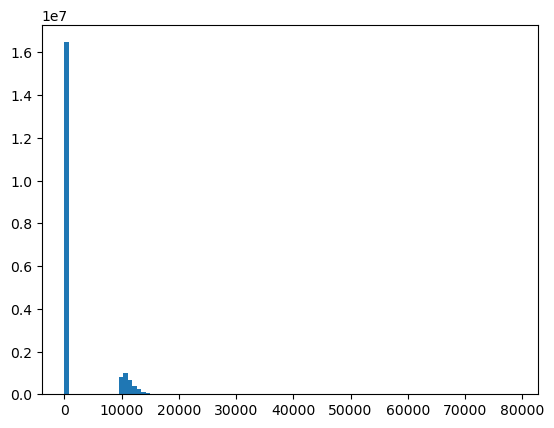

In [32]:
plt.hist(df_final['time'], bins = 100)

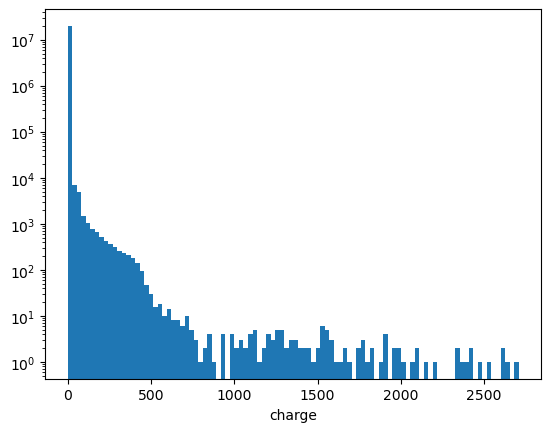

In [33]:
#Study the distribution of the variables and targets

plt.hist(df_final['charge'], bins = 100)
plt.xlabel("charge")
plt.yscale('log')

In [34]:
X.shape

(200000, 300)

In [35]:
model = keras.Sequential([layers.Dense(units=512, input_shape= [300], activation = 'relu'),
                         layers.Dense(units = 512, activation = 'relu'),
                         layers.Dense(units = 512, activation = 'relu'),
                         layers.Dense(units = 512, activation = 'relu'),
                         layers.Dense(units = 512, activation = 'relu'),
                         layers.Dense(units = 512, activation = 'relu'),
                         layers.Dense(units = 512, activation = 'relu'),
                         layers.Dense(units= 2, activation = 'linear')])

predicted_X = model.predict(X)


model.compile(optimizer=Adam(learning_rate= 0.0001), loss = angular_dist_score)

6250/6250 [==============================] - 28s 4ms/step


In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               154112    
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 dense_6 (Dense)             (None, 512)               2

Epoch 1/30
1094/1094 [==============================] - 31s 27ms/step - loss: 1.5428 - val_loss: 1.5448
Epoch 2/30
1094/1094 [==============================] - 28s 26ms/step - loss: 1.5552 - val_loss: 1.5387
Epoch 3/30
1094/1094 [==============================] - 29s 26ms/step - loss: 1.5427 - val_loss: 1.5389
Epoch 4/30
1094/1094 [==============================] - 28s 26ms/step - loss: 1.5416 - val_loss: 1.5367
Epoch 5/30
1094/1094 [==============================] - 28s 26ms/step - loss: 1.5398 - val_loss: 1.5376
Epoch 6/30
1094/1094 [==============================] - 30s 28ms/step - loss: 1.5402 - val_loss: 1.5362
Epoch 7/30
1094/1094 [==============================] - 28s 26ms/step - loss: 1.5398 - val_loss: 1.5370
Epoch 8/30
1094/1094 [==============================] - 28s 26ms/step - loss: 1.5407 - val_loss: 1.5364
Epoch 9/30
1094/1094 [==============================] - 28s 26ms/step - loss: 1.5402 - val_loss: 1.5353
Epoch 10/30
1094/1094 [==============================] - 28s 26m

<AxesSubplot:>

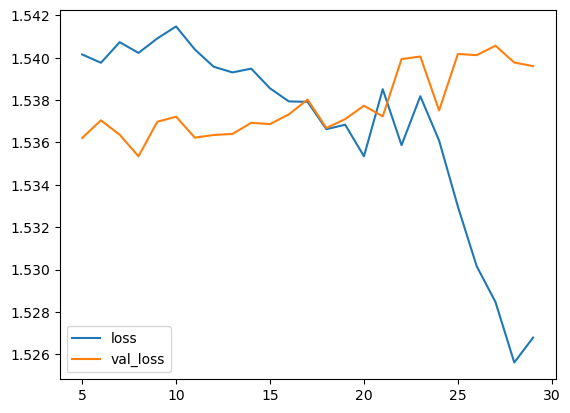

In [37]:
history = model.fit(X, Y,batch_size=128,epochs=30, validation_split = 0.3)
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5. You can change this to get a different view.
history_df.loc[5:, ['loss', 'val_loss']].plot()


In [38]:
print(X.shape)

(200000, 300)
